In [5]:
from Graph import Graph

# initialize graph
graph = Graph()

In [6]:
# retrieve active_player_histories-- this will be used to create connections
import pandas as pd
from datetime import datetime

# initialize players dict for O(1) lookup of player information
players_csv = pd.read_csv("active_players_nba_2023.csv")
players = {}

for row in players_csv.iterrows():
    content = row[1]
    players[content["id"]] = content["name"]


player_trades = pd.read_csv("active_player_histories_nba.csv")
player_trades.fillna(datetime.today().strftime('%Y-%m-%d'), inplace=True)
player_trades.sort_values("end", inplace=True, ascending=False)
player_trades.head(5)
# insertion will be done by generating current teams and replaying trades from present -> past
# the sorting allows this



,Unnamed: 0,player_id,player_name,team,start,end
0,0,817057,DeMar DeRozan,Chicago Bulls,2021-08-02,2023-05-07
697,0,817022,Clint Capela,Atlanta Hawks,2020-02-04,2023-05-07
700,1181233,1181233,AJ Griffin,Atlanta Hawks,2023-05-07,2023-05-07
701,0,1133787,Jalen Johnson,Atlanta Hawks,2021-07-28,2023-05-07
702,0,987933,Jarrett Culver,Memphis Grizzlies,2021-08-16,2023-05-07


In [7]:
import heapq
import datetime

current_date = None
teams = {}
current_team = {}

# remove at start_date
next_date = []
remove_date_map = {}

# this code will break at 9001
BIG_DATE = datetime.datetime.strptime("9001-12-25", "%Y-%m-%d").date()

def remove_from_team(player):
    curr_team = current_team.get(player)
    if curr_team != None: 
        del current_team[player]
        teams[curr_team].remove(player)

def add_to_team(player, team, start_date):
    # init team if not initialized
    teams[team] = teams.get(team, set())

    # remove player from their current team
    remove_from_team(player)

    # set player current team
    current_team[player] = team

    if remove_date_map.get(start_date) == None:
        remove_date_map[start_date] = []
    
    start_date_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    heapq.heappush(next_date, ((BIG_DATE - start_date_dt).days, start_date))
    remove_date_map[start_date].append(player)

    # add player to team
    teams[team].add(player)

def connect_players(players):
    players = list(players) # convert to an array, so we can index[0]

    for i in range(len(players)):
        curr_player = players[i]
        for j in range(i + 1, len(players)):
            connect_player = players[j]
            graph.addNeighbor(curr_player, connect_player)

# this connects all teams at their current state
def flush_teams():
    global current_date
    for _, players in teams.items():
        connect_players(players)
    current_date = None

# iterate through all player trades
for row in player_trades.iterrows():
    content = row[1]
    date = content["end"]

    if current_date != date:
         flush_teams()

    if current_date == None:
        current_date = date

        # remove all players based on their start date
        while len(next_date) > 0:
            date_to_compare = next_date[0][1]
            if date_to_compare < current_date:
                break

            heapq.heappop(next_date)
            for player in remove_date_map[date_to_compare]:
                remove_from_team(player)
    
    add_to_team(content["player_id"], content["team"], content["start"])



In [9]:
import networkx as nx
from community.community_louvain import best_partition
import matplotlib.pyplot as plt
import numpy as np

networkG = nx.Graph(graph.connections)
pos = nx.spring_layout(networkG, k=.2)
partition = best_partition(networkG)

clusters = set(partition.values())
color_list = plt.cm.viridis(np.linspace(0, 1, len(clusters)))
color_list = ['#%02x%02x%02x' % (int(r * 255), int(g * 255), int(b * 255)) for r, g, b, _ in color_list]

cluster_color = {
    cluster: color_list[cluster] 
    for cluster in clusters
}

output = {
    "edges": [],
    "nodes": []
}

max_edges = 0

# fill edges
for source, targets in graph.connections.items():
    max_edges = max(max_edges, len(targets))
    for target in targets:
        output["edges"].append({
            "source": source,
            "target": target,
            "line": "dotted"
        })


largest_node_size = 7.5


# fill nodess
for key, value in pos.items():
    cluster = partition[key]
    output["nodes"].append({
        "cluster": cluster,
        "color": cluster_color[cluster],
        "key": key,
        "id": key,
        "x": value[0],
        "y": value[1],
        "size": len(graph.connections[key])/max_edges * largest_node_size,
        "label": players[key]
    })

import json

with open("../data.json", "w") as outfile:
    json.dump(output, outfile)


  Using cached python-louvain-0.16.tar.gz (204 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9388 sha256=2bf663a2f07fe0b42f34499c5e844f46504c2d866c576acbd41b835edf5114cb
  Stored in directory: /Users/foshes/Library/Caches/pip/wheels/e0/2c/33/8b5604f69c4a6ed10fb867d51173c03f666920c7c8bbcedbaa
Successfully built python-louvain


1092866 1132134
1092866 1132126
1092866 1180496
1092866 1389948
1092866 1178910
1179043 1132134
1179043 1132126
1179043 1180496
1179043 1389948
1179043 1178910
1092036 1132134
1092036 1132126
1092036 1180496
1092036 1389948
1092036 1178910
1181233 1132134
1181233 1132126
1181233 1180496
1181233 1389948
1181233 1178910
1178199 1132134
1178199 1132126
1178199 1180496
1178199 1389948
1178199 1178910
1181091 1094164
1181091 1178446
988875 1094164
988875 1178446
1178858 1094164
1178858 1178446
1179536 1094164
1179536 1178446
1178033 1094164
1178033 1178446
1180179 1094164
1180179 1178446


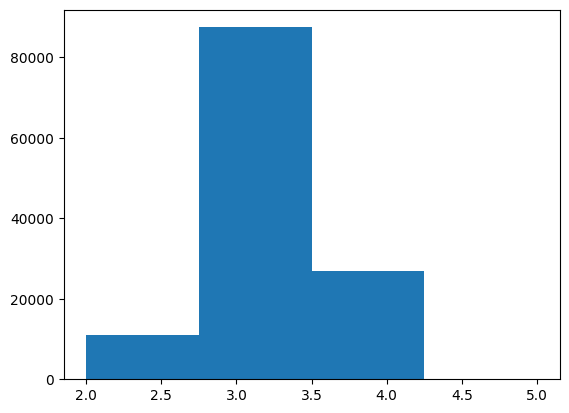

In [22]:
# import matplotlib.pyplot as plt

# players = list(graph.connections.keys())
# data = []

# for i in range(len(players)):
#     player0 = players[i]
#     for j in range(i + 1, len(players)):
#         player1 = players[j]
#         data.append(len(graph.bfs(player0, player1)))

#         if len(graph.bfs(player0, player1)) == 5:
#             print(player0, player1)

# plt.hist(data, bins=len(set(data)))
# plt.show()



In [ ]:
graph.bfs(1178199, 817181)

[1178199, 988300, 817181]